In [ ]:
# This is for compatibility with google colab
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/MultiOmicsIntegration/comp-401

Mounted at /content/drive
/content/drive/MyDrive/MultiOmicsIntegration/comp-401


In [ ]:
!pip install lifelines

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.2/349.2 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.2/94.2 kB 11.9 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=5fc494d34c019ef067b2a50ab9230d0971d0b48419f579c010708a554020af50
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from lifelines.utils import concordance_index
from lifelines import CoxPHFitter
from sklearn.preprocessing import StandardScaler

from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
import json

import os
np.random.seed(1234)
seed = 1234
np.random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)

In [ ]:
%cd /content/drive/MyDrive/MultiOmicsIntegration/comp-401/notebooks

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/notebooks


# KIPAN Staging

### Import marker genes

In [ ]:
# Loading in marker genes per modality
with open("results/kipan/staging/marker_genes.json",'r+') as file:
    genes = json.load(file)

In [ ]:
chosen_genes = {}
for modality in genes:
  chosen_genes[modality] = np.array(genes[modality])
  print(f"{modality}: {len(chosen_genes[modality])}")

rna: 40
meth: 15
rppa: 16


In [ ]:
#chosen_genes = pd.read_csv("PAAD_deg.csv", header=None).values.flatten() ## your markers genes
'''chosen_genes_sc = pd.read_csv("PAAD_deg_sc.csv", header=None).values.flatten()
chosen_genes_scAB = pd.read_csv("PAAD_deg_scAB.csv", header=None).values.flatten()
chosen_genes_degas = pd.read_csv("PAAD_deg_degas.csv", header=None).values.flatten()
chosen_genes_bulk = pd.read_csv("up_genes_deseq_PAAD.csv").values.flatten()'''

'chosen_genes_sc = pd.read_csv("PAAD_deg_sc.csv", header=None).values.flatten()\nchosen_genes_scAB = pd.read_csv("PAAD_deg_scAB.csv", header=None).values.flatten()\nchosen_genes_degas = pd.read_csv("PAAD_deg_degas.csv", header=None).values.flatten()\nchosen_genes_bulk = pd.read_csv("up_genes_deseq_PAAD.csv").values.flatten()'

### Import count bulk data and phenotype data (survival data)

In [ ]:
datasets = {
            'rna': '../data/kipan/staging/RNASeq.csv',
            'meth': '../data/kipan/staging/Methylation.csv',
            'rppa': '../data/kipan/staging/RPPA.csv',
}

labels = '../data/kipan/staging/Clinical.csv'

In [ ]:
data = {}
pheno = {}
result = {}

for modality in datasets:
  data[modality] = pd.read_csv(datasets[modality], index_col=0, delimiter=",")  ## import your bulk dataset
  #inter[modality] = pd.read_csv("PAAD/inter_PAAD.csv").iloc[:, 1:].values.reshape(1, -1)[0] ## disregard this

  #data = data.filter(items=inter) ## disregard this
  pheno[modality] = pd.read_csv(labels, index_col=0) ## phenotype information e.g survival data
  result[modality] = pd.concat([pheno[modality], data[modality]], axis=1) ## merging the bulk and phenotype data
  result[modality].dropna(inplace=True)

  result[modality].rename(
      columns={"survival_time": "duration", "status": "event"},
      inplace=True,
  )

  '''pre_x = result[modality].iloc[:, 2:].values.copy()
  scaler = MinMaxScaler()
  scaler.fit(np.log(1 + pre_x))
  new_x = np.log(1 + pre_x)
  result[modality].iloc[:, 2:] = new_x.copy()'''

In [ ]:
data['rna']

,A1BG_rna,A1CF_rna,A2BP1_rna,A2LD1_rna,A2ML1_rna,A2M_rna,A4GALT_rna,A4GNT_rna,AAA1_rna,AAAS_rna,...,ZXDA_rna,ZXDB_rna,ZXDC_rna,ZYG11A_rna,ZYG11B_rna,ZYX_rna,ZZEF1_rna,ZZZ3_rna,psiTPTE22_rna,tAKR_rna
SubjectID,,,,,,,,,,,,,,,,,,,,,
TCGA.KL.8324,2.9220,0.5557,0.5557,6.4226,0.0000,12.5766,8.4066,0.0000,0.0000,10.0178,...,5.8309,9.2943,9.9057,0.5557,9.5418,10.7716,10.2948,8.2683,3.7748,0.5557
TCGA.KL.8325,3.1717,1.2235,2.5867,4.9979,0.0000,12.2548,6.0020,0.0000,0.4155,9.5308,...,6.3478,9.2131,10.5964,0.7378,11.9088,9.5732,10.2248,9.2523,3.5044,0.4155
TCGA.KL.8326,7.0628,0.0000,1.3121,6.0077,0.5796,12.1954,9.9291,0.0000,0.0000,9.6605,...,4.8911,8.3653,9.7967,0.0000,10.4755,10.2113,10.4287,10.0247,9.3258,0.0000
TCGA.KL.8327,5.5324,0.9586,0.9586,4.5546,0.0000,12.4552,9.7941,0.0000,0.0000,10.4048,...,4.6740,8.3674,9.8644,0.0000,10.3328,10.5289,9.9754,9.2604,8.6777,2.2551
TCGA.KL.8328,5.1086,0.0000,6.9727,5.1014,0.5391,11.3552,7.2850,0.5391,0.0000,10.6948,...,5.4157,8.6281,10.5554,0.9307,10.3889,10.7872,10.2482,8.7576,5.1655,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA.Y8.A897,5.6219,4.5046,0.0000,6.8210,0.0000,12.7798,10.5302,4.6443,0.0000,9.8040,...,5.5455,7.8656,10.0272,1.2540,9.9864,12.5126,10.0233,9.6096,8.2755,0.0000
TCGA.Y8.A8RY,6.2065,4.1973,2.0060,6.7941,1.3267,12.4133,10.9746,4.9619,0.4616,10.5466,...,5.7186,8.0226,10.0221,0.4616,9.7233,13.1499,10.9972,9.5728,8.4013,0.0000
TCGA.Y8.A8RZ,5.0941,4.9398,0.0000,7.2842,0.0000,12.1129,9.0241,2.7946,0.0000,9.9922,...,6.8370,8.2636,9.7812,0.5800,9.4850,12.1866,10.3860,9.6326,3.3085,0.0000


In [ ]:
pheno['rna']

,histological_type,pathologic_stage,survival_time,status
SubjectID,,,,
TCGA.KL.8324,kidneychromophobe,stageii,4676.0,0.0
TCGA.KL.8325,kidneychromophobe,stageii,725.0,1.0
TCGA.KL.8326,kidneychromophobe,stageiii,3322.0,0.0
TCGA.KL.8327,kidneychromophobe,stagei,4169.0,0.0
TCGA.KL.8328,kidneychromophobe,stageii,3127.0,0.0
...,...,...,...,...
TCGA.Y8.A897,kidneypapillaryrenalcellcarcinoma,stagei,549.0,0.0
TCGA.Y8.A8RY,kidneypapillaryrenalcellcarcinoma,stagei,769.0,0.0
TCGA.Y8.A8RZ,kidneypapillaryrenalcellcarcinoma,stagei,205.0,0.0


In [ ]:
result['rna']

,histological_type,pathologic_stage,duration,event,A1BG_rna,A1CF_rna,A2BP1_rna,A2LD1_rna,A2ML1_rna,A2M_rna,...,ZXDA_rna,ZXDB_rna,ZXDC_rna,ZYG11A_rna,ZYG11B_rna,ZYX_rna,ZZEF1_rna,ZZZ3_rna,psiTPTE22_rna,tAKR_rna
SubjectID,,,,,,,,,,,,,,,,,,,,,
TCGA.KL.8324,kidneychromophobe,stageii,4676.0,0.0,2.9220,0.5557,0.5557,6.4226,0.0000,12.5766,...,5.8309,9.2943,9.9057,0.5557,9.5418,10.7716,10.2948,8.2683,3.7748,0.5557
TCGA.KL.8325,kidneychromophobe,stageii,725.0,1.0,3.1717,1.2235,2.5867,4.9979,0.0000,12.2548,...,6.3478,9.2131,10.5964,0.7378,11.9088,9.5732,10.2248,9.2523,3.5044,0.4155
TCGA.KL.8326,kidneychromophobe,stageiii,3322.0,0.0,7.0628,0.0000,1.3121,6.0077,0.5796,12.1954,...,4.8911,8.3653,9.7967,0.0000,10.4755,10.2113,10.4287,10.0247,9.3258,0.0000
TCGA.KL.8327,kidneychromophobe,stagei,4169.0,0.0,5.5324,0.9586,0.9586,4.5546,0.0000,12.4552,...,4.6740,8.3674,9.8644,0.0000,10.3328,10.5289,9.9754,9.2604,8.6777,2.2551
TCGA.KL.8328,kidneychromophobe,stageii,3127.0,0.0,5.1086,0.0000,6.9727,5.1014,0.5391,11.3552,...,5.4157,8.6281,10.5554,0.9307,10.3889,10.7872,10.2482,8.7576,5.1655,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA.Y8.A897,kidneypapillaryrenalcellcarcinoma,stagei,549.0,0.0,5.6219,4.5046,0.0000,6.8210,0.0000,12.7798,...,5.5455,7.8656,10.0272,1.2540,9.9864,12.5126,10.0233,9.6096,8.2755,0.0000
TCGA.Y8.A8RY,kidneypapillaryrenalcellcarcinoma,stagei,769.0,0.0,6.2065,4.1973,2.0060,6.7941,1.3267,12.4133,...,5.7186,8.0226,10.0221,0.4616,9.7233,13.1499,10.9972,9.5728,8.4013,0.0000
TCGA.Y8.A8RZ,kidneypapillaryrenalcellcarcinoma,stagei,205.0,0.0,5.0941,4.9398,0.0000,7.2842,0.0000,12.1129,...,6.8370,8.2636,9.7812,0.5800,9.4850,12.1866,10.3860,9.6326,3.3085,0.0000


### Filter out non-marker genes from result dataframe

In [ ]:
filtered_result = {}

for modality in chosen_genes:
  DEG_genes = np.append(chosen_genes[modality], ["duration", "event"])
  filtered_result[modality] = result[modality].filter(DEG_genes) ## filter out non-marker genes from dataset

In [ ]:
filtered_result['rna']

,LCN1_rna,ITIH4_rna,KERA_rna,CRABP1_rna,NCAM1_rna,C1orf61_rna,GPR109B_rna,FAM101A_rna,VWA3A_rna,H19_rna,...,DHRS2_rna,CGB8_rna,CXCL17_rna,KRT19_rna,CHST2_rna,MXRA5_rna,AEBP1_rna,GRIA2_rna,duration,event
SubjectID,,,,,,,,,,,,,,,,,,,,,
TCGA.KL.8324,0.0000,3.6722,0.0000,2.9220,8.1299,2.3866,6.8654,5.2166,0.5557,12.0184,...,14.8965,0.0,0.0000,5.4671,11.5351,6.5408,9.9907,12.0249,4676.0,0.0
TCGA.KL.8325,0.0000,3.2748,0.0000,0.0000,8.5124,1.2235,8.4311,7.4477,0.7378,9.5032,...,14.6582,0.0,0.4155,8.0262,13.4526,4.2499,6.4885,0.0000,725.0,1.0
TCGA.KL.8326,0.9919,3.3776,0.0000,1.5741,4.6282,0.5796,4.5080,1.5741,0.0000,9.5122,...,11.6287,0.0,0.0000,5.9497,10.7256,5.8419,8.9189,0.0000,3322.0,0.0
TCGA.KL.8327,0.0000,5.8000,0.0000,0.9586,7.9442,2.2551,1.9374,5.1661,1.9374,9.6182,...,10.1484,0.0,0.0000,7.8705,10.6759,6.1459,8.8170,2.5153,4169.0,0.0
TCGA.KL.8328,2.3442,3.7747,0.0000,5.4157,2.4675,2.6864,5.0714,3.8217,0.0000,10.3991,...,9.3124,0.0,1.2384,7.5694,12.9390,6.5598,8.5183,0.5391,3127.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA.Y8.A897,0.0000,5.5455,0.9437,0.0000,5.5597,0.5476,3.9795,1.5093,5.0582,7.5003,...,0.9437,0.0,1.2540,10.5824,5.9742,11.6037,10.5632,0.0000,549.0,0.0
TCGA.Y8.A8RY,0.0000,6.8369,0.0000,0.0000,2.3640,1.0917,3.8654,3.2739,3.1568,10.1060,...,1.7059,0.0,0.0000,13.9946,6.2343,10.2766,12.1978,1.3267,769.0,0.0
TCGA.Y8.A8RZ,0.0000,4.6581,0.0000,4.1152,4.1954,0.5800,0.5800,1.9888,0.0000,11.1597,...,2.3100,0.0,0.0000,11.7935,9.2991,6.7200,8.9100,0.0000,205.0,0.0


### Run cox-regression

In [ ]:
from lifelines import CoxPHFitter

new_df = {}
info = {}
T = {}
E = {}

for modality in datasets:
  cph = CoxPHFitter(penalizer=0.1) ## initialise cox regression model
  cph.fit(filtered_result[modality], duration_col="duration", event_col="event") ## run cox regression

  info[modality] = cph.summary ## regression summary
  DEG_exp = filtered_result[modality]
  DEG_coef = info[modality].T.filter(chosen_genes[modality]).iloc[0] ## get feature (genes) coefficients
  exp = DEG_exp.iloc[:, :-2].values ## get genes expression alone (apart from survival data)
  coef = DEG_coef.values.reshape(-1, 1)
  risk_scores = np.dot(exp, coef) ## matrix multiplication (gene1 expression * coefficient of gene1) = risk score of gene1

  ## Here we create a new dataframe with the risk scores for each marker genes, thats how you stratify between high and background risk patients
  new_df[modality] = DEG_exp.iloc[:, -2:]
  new_df[modality]["scores"] = risk_scores
  median_risk = np.median(risk_scores)
  risk = ["high" if i >= median_risk else "low" for i in risk_scores] ## patient straticication using median risk score
  new_df[modality]["risk"] = risk
  new_df[modality].reset_index(inplace=True)
  new_df[modality]

  T[modality] = new_df[modality]["duration"].values
  E[modality] = new_df[modality]["event"].values

In [ ]:
info['rna']

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
LCN1_rna,-0.126344,0.881312,0.099066,-0.320510,0.067822,0.725779,1.070175,0.0,-1.275348,0.202186,2.306244
ITIH4_rna,0.146603,1.157894,0.041625,0.065020,0.228186,1.067181,1.256319,0.0,3.522027,0.000428,11.189223
KERA_rna,0.002243,1.002245,0.076052,-0.146816,0.151301,0.863453,1.163347,0.0,0.029491,0.976473,0.034348
CRABP1_rna,-0.045847,0.955188,0.040690,-0.125598,0.033905,0.881969,1.034486,0.0,-1.126724,0.259859,1.944197
NCAM1_rna,0.003245,1.003250,0.032644,-0.060736,0.067226,0.941072,1.069537,0.0,0.099408,0.920815,0.119017
C1orf61_rna,0.009214,1.009256,0.072102,-0.132104,0.150532,0.876250,1.162453,0.0,0.127788,0.898317,0.154704
GPR109B_rna,-0.039489,0.961281,0.043740,-0.125217,0.046239,0.882305,1.047325,0.0,-0.902816,0.366624,1.447628
FAM101A_rna,0.017123,1.017271,0.036808,-0.055019,0.089265,0.946467,1.093371,0.0,0.465207,0.641783,0.639842
VWA3A_rna,-0.016164,0.983966,0.048963,-0.112130,0.079803,0.893928,1.083073,0.0,-0.330119,0.741310,0.431852


In [ ]:
new_df['rna']

,SubjectID,duration,event,scores,risk
0,TCGA.KL.8324,4676.0,0.0,1.504082,low
1,TCGA.KL.8325,725.0,1.0,0.987073,low
2,TCGA.KL.8326,3322.0,0.0,1.167537,low
3,TCGA.KL.8327,4169.0,0.0,1.996112,high
4,TCGA.KL.8328,3127.0,0.0,1.088209,low
...,...,...,...,...,...
535,TCGA.Y8.A897,549.0,0.0,1.668459,low
536,TCGA.Y8.A8RY,769.0,0.0,2.068568,high
537,TCGA.Y8.A8RZ,205.0,0.0,2.541878,high
538,TCGA.Y8.A8S0,183.0,0.0,1.418981,low


### Create KM-PLOT

In [ ]:
from lifelines.statistics import logrank_test

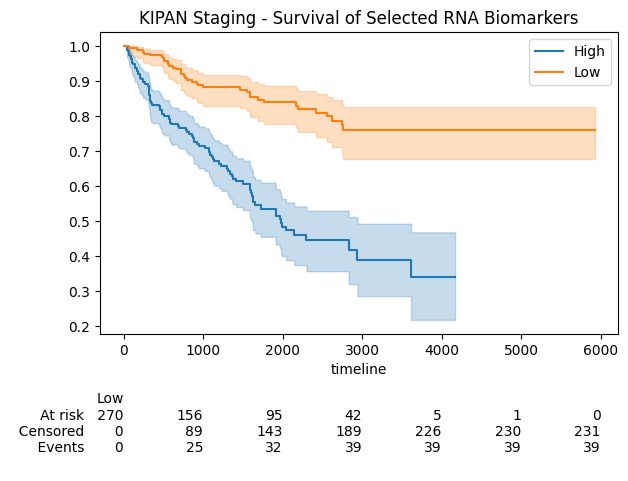

p-value: 2.880954339137025e-13


In [ ]:
  ax = plt.subplot(111)
  m_1 = new_df['rna']["risk"] == "high"
  kmf_1 = KaplanMeierFitter()
  kmf_1.fit(durations=T['rna'][m_1], event_observed=E['rna'][m_1], label="High")
  kmf_1.plot_survival_function(ax=ax)
  kmf_1.fit(T['rna'][~m_1], event_observed=E['rna'][~m_1], label="Low")
  kmf_1.plot_survival_function(ax=ax, at_risk_counts=True)
  plt.title(f"KIPAN Staging - Survival of Selected RNA Biomarkers")
  plt.show()

  results = logrank_test(T['rna'][m_1], T['rna'][~m_1], event_observed_A=E['rna'][m_1], event_observed_B=E['rna'][~m_1])
  print("p-value: " + str(results.p_value))

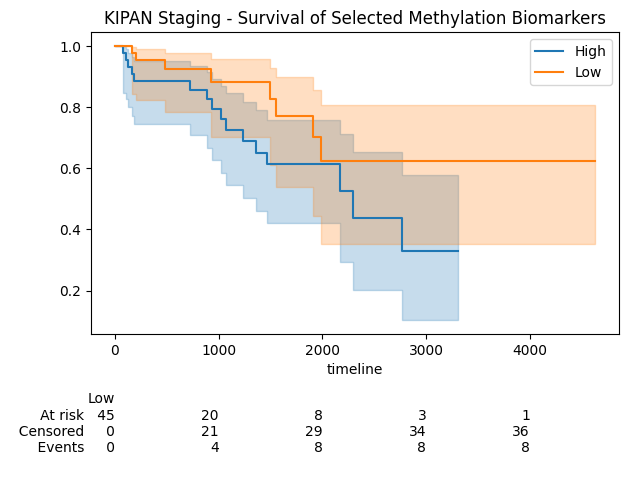

p-value: 0.1281217781182484


In [ ]:
  ax = plt.subplot(111)
  m_1 = new_df['meth']["risk"] == "high"
  kmf_1 = KaplanMeierFitter()
  kmf_1.fit(durations=T['meth'][m_1], event_observed=E['meth'][m_1], label="High")
  kmf_1.plot_survival_function(ax=ax)
  kmf_1.fit(T['meth'][~m_1], event_observed=E['meth'][~m_1], label="Low")
  kmf_1.plot_survival_function(ax=ax, at_risk_counts=True)
  plt.title(f"KIPAN Staging - Survival of Selected Methylation Biomarkers")
  plt.show()

  results = logrank_test(T['meth'][m_1], T['meth'][~m_1], event_observed_A=E['meth'][m_1], event_observed_B=E['meth'][~m_1])
  print("p-value: " + str(results.p_value))

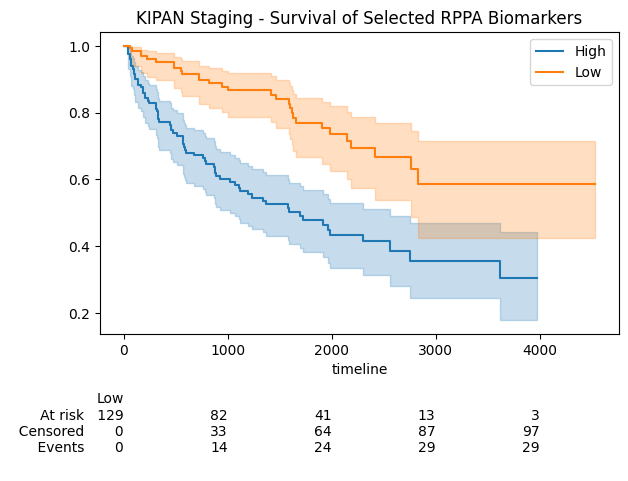

p-value: 1.0766913763088581e-06


In [ ]:
  ax = plt.subplot(111)
  m_1 = new_df['rppa']["risk"] == "high"
  kmf_1 = KaplanMeierFitter()
  kmf_1.fit(durations=T['rppa'][m_1], event_observed=E['rppa'][m_1], label="High")
  kmf_1.plot_survival_function(ax=ax)
  kmf_1.fit(T['rppa'][~m_1], event_observed=E['rppa'][~m_1], label="Low")
  kmf_1.plot_survival_function(ax=ax, at_risk_counts=True)
  plt.title(f"KIPAN Staging - Survival of Selected RPPA Biomarkers")
  plt.show()

  results = logrank_test(T['rppa'][m_1], T['rppa'][~m_1], event_observed_A=E['rppa'][m_1], event_observed_B=E['rppa'][~m_1])
  print("p-value: " + str(results.p_value))

# KIPAN Subtyping

### Import marker genes

In [ ]:
# Loading in marker genes per modality
with open("results/kipan/subtyping/marker_genes.json",'r+') as file:
    genes = json.load(file)

In [ ]:
chosen_genes = {}
for modality in genes:
  chosen_genes[modality] = np.array(genes[modality])
  print(f"{modality}: {len(chosen_genes[modality])}")

rna: 0
cnv: 58
rppa: 62


### Import count bulk data and phenotype data (survival data)

In [ ]:
datasets = {
            'rna': '../data/kipan/subtyping/RNASeq.csv',
            'cnv': '../data/kipan/subtyping/CNV.csv',
            'rppa': '../data/kipan/subtyping/RPPA.csv',
}

labels = '../data/kipan/subtyping/Clinical.csv'

In [ ]:
data = {}
pheno = {}
result = {}

for modality in datasets:
  data[modality] = pd.read_csv(datasets[modality], index_col=0, delimiter=",")  ## import your bulk dataset
  #inter[modality] = pd.read_csv("PAAD/inter_PAAD.csv").iloc[:, 1:].values.reshape(1, -1)[0] ## disregard this

  #data = data.filter(items=inter) ## disregard this
  pheno[modality] = pd.read_csv(labels, index_col=0) ## phenotype information e.g survival data
  result[modality] = pd.concat([pheno[modality], data[modality]], axis=1) ## merging the bulk and phenotype data
  result[modality].dropna(inplace=True)

  result[modality].rename(
      columns={"survival_time": "duration", "status": "event"},
      inplace=True,
  )

In [ ]:
data['rna']

,A1BG_rna,A1CF_rna,A2BP1_rna,A2LD1_rna,A2ML1_rna,A2M_rna,A4GALT_rna,A4GNT_rna,AAA1_rna,AAAS_rna,...,ZXDA_rna,ZXDB_rna,ZXDC_rna,ZYG11A_rna,ZYG11B_rna,ZYX_rna,ZZEF1_rna,ZZZ3_rna,psiTPTE22_rna,tAKR_rna
SubjectID,,,,,,,,,,,,,,,,,,,,,
TCGA.KL.8324,2.9220,0.5557,0.5557,6.4226,0.0000,12.5766,8.4066,0.0000,0.0000,10.0178,...,5.8309,9.2943,9.9057,0.5557,9.5418,10.7716,10.2948,8.2683,3.7748,0.5557
TCGA.KL.8325,3.1717,1.2235,2.5867,4.9979,0.0000,12.2548,6.0020,0.0000,0.4155,9.5308,...,6.3478,9.2131,10.5964,0.7378,11.9088,9.5732,10.2248,9.2523,3.5044,0.4155
TCGA.KL.8326,7.0628,0.0000,1.3121,6.0077,0.5796,12.1954,9.9291,0.0000,0.0000,9.6605,...,4.8911,8.3653,9.7967,0.0000,10.4755,10.2113,10.4287,10.0247,9.3258,0.0000
TCGA.KL.8327,5.5324,0.9586,0.9586,4.5546,0.0000,12.4552,9.7941,0.0000,0.0000,10.4048,...,4.6740,8.3674,9.8644,0.0000,10.3328,10.5289,9.9754,9.2604,8.6777,2.2551
TCGA.KL.8328,5.1086,0.0000,6.9727,5.1014,0.5391,11.3552,7.2850,0.5391,0.0000,10.6948,...,5.4157,8.6281,10.5554,0.9307,10.3889,10.7872,10.2482,8.7576,5.1655,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA.Y8.A897,5.6219,4.5046,0.0000,6.8210,0.0000,12.7798,10.5302,4.6443,0.0000,9.8040,...,5.5455,7.8656,10.0272,1.2540,9.9864,12.5126,10.0233,9.6096,8.2755,0.0000
TCGA.Y8.A8RY,6.2065,4.1973,2.0060,6.7941,1.3267,12.4133,10.9746,4.9619,0.4616,10.5466,...,5.7186,8.0226,10.0221,0.4616,9.7233,13.1499,10.9972,9.5728,8.4013,0.0000
TCGA.Y8.A8RZ,5.0941,4.9398,0.0000,7.2842,0.0000,12.1129,9.0241,2.7946,0.0000,9.9922,...,6.8370,8.2636,9.7812,0.5800,9.4850,12.1866,10.3860,9.6326,3.3085,0.0000


In [ ]:
pheno['rna']

,histological_type,pathologic_stage,survival_time,status
SubjectID,,,,
TCGA.KL.8324,kidneychromophobe,stageii,4676.0,0.0
TCGA.KL.8325,kidneychromophobe,stageii,725.0,1.0
TCGA.KL.8326,kidneychromophobe,stageiii,3322.0,0.0
TCGA.KL.8327,kidneychromophobe,stagei,4169.0,0.0
TCGA.KL.8328,kidneychromophobe,stageii,3127.0,0.0
...,...,...,...,...
TCGA.Y8.A897,kidneypapillaryrenalcellcarcinoma,stagei,549.0,0.0
TCGA.Y8.A8RY,kidneypapillaryrenalcellcarcinoma,stagei,769.0,0.0
TCGA.Y8.A8RZ,kidneypapillaryrenalcellcarcinoma,stagei,205.0,0.0


In [ ]:
result['rna']

,histological_type,pathologic_stage,duration,event,A1BG_rna,A1CF_rna,A2BP1_rna,A2LD1_rna,A2ML1_rna,A2M_rna,...,ZXDA_rna,ZXDB_rna,ZXDC_rna,ZYG11A_rna,ZYG11B_rna,ZYX_rna,ZZEF1_rna,ZZZ3_rna,psiTPTE22_rna,tAKR_rna
SubjectID,,,,,,,,,,,,,,,,,,,,,
TCGA.KL.8324,kidneychromophobe,stageii,4676.0,0.0,2.9220,0.5557,0.5557,6.4226,0.0000,12.5766,...,5.8309,9.2943,9.9057,0.5557,9.5418,10.7716,10.2948,8.2683,3.7748,0.5557
TCGA.KL.8325,kidneychromophobe,stageii,725.0,1.0,3.1717,1.2235,2.5867,4.9979,0.0000,12.2548,...,6.3478,9.2131,10.5964,0.7378,11.9088,9.5732,10.2248,9.2523,3.5044,0.4155
TCGA.KL.8326,kidneychromophobe,stageiii,3322.0,0.0,7.0628,0.0000,1.3121,6.0077,0.5796,12.1954,...,4.8911,8.3653,9.7967,0.0000,10.4755,10.2113,10.4287,10.0247,9.3258,0.0000
TCGA.KL.8327,kidneychromophobe,stagei,4169.0,0.0,5.5324,0.9586,0.9586,4.5546,0.0000,12.4552,...,4.6740,8.3674,9.8644,0.0000,10.3328,10.5289,9.9754,9.2604,8.6777,2.2551
TCGA.KL.8328,kidneychromophobe,stageii,3127.0,0.0,5.1086,0.0000,6.9727,5.1014,0.5391,11.3552,...,5.4157,8.6281,10.5554,0.9307,10.3889,10.7872,10.2482,8.7576,5.1655,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA.Y8.A897,kidneypapillaryrenalcellcarcinoma,stagei,549.0,0.0,5.6219,4.5046,0.0000,6.8210,0.0000,12.7798,...,5.5455,7.8656,10.0272,1.2540,9.9864,12.5126,10.0233,9.6096,8.2755,0.0000
TCGA.Y8.A8RY,kidneypapillaryrenalcellcarcinoma,stagei,769.0,0.0,6.2065,4.1973,2.0060,6.7941,1.3267,12.4133,...,5.7186,8.0226,10.0221,0.4616,9.7233,13.1499,10.9972,9.5728,8.4013,0.0000
TCGA.Y8.A8RZ,kidneypapillaryrenalcellcarcinoma,stagei,205.0,0.0,5.0941,4.9398,0.0000,7.2842,0.0000,12.1129,...,6.8370,8.2636,9.7812,0.5800,9.4850,12.1866,10.3860,9.6326,3.3085,0.0000


### Filter out non-marker genes from result dataframe

In [ ]:
filtered_result = {}

for modality in chosen_genes:
  DEG_genes = np.append(chosen_genes[modality], ["duration", "event"])
  filtered_result[modality] = result[modality].filter(DEG_genes) ## filter out non-marker genes from dataset

In [ ]:
# We can see there were no selected biomarkers for RNA
filtered_result['rna']

,duration,event
SubjectID,,
TCGA.KL.8324,4676.0,0.0
TCGA.KL.8325,725.0,1.0
TCGA.KL.8326,3322.0,0.0
TCGA.KL.8327,4169.0,0.0
TCGA.KL.8328,3127.0,0.0
...,...,...
TCGA.Y8.A897,549.0,0.0
TCGA.Y8.A8RY,769.0,0.0
TCGA.Y8.A8RZ,205.0,0.0


In [ ]:
filtered_result['cnv']

,LARGE_cnv,SEMA3E_cnv,ZNF716_cnv,MIR3147_cnv,ZNF479_cnv,RN7SL816P_cnv,SGCG_cnv,CDH18_cnv,CLIC6_cnv,CADM2_cnv,...,CAMK1D_cnv,PGR_cnv,SLC30A10_cnv,SNTG1_cnv,DSG3_cnv,CCDC120_cnv,PAK7_cnv,SLC39A11_cnv,duration,event
SubjectID,,,,,,,,,,,,,,,,,,,,,
TCGA.KL.8324,0.376,0.628,0.628,0.628,0.628,0.628,-0.474,-0.465,-0.496,-0.457,...,0.542,0.619,-0.467,0.625,0.615,0.000,0.507,-0.519,4676.0,0.0
TCGA.KL.8325,0.067,0.003,0.013,0.013,0.013,0.013,-0.003,0.016,-0.848,0.014,...,-0.857,0.023,-0.840,0.007,0.009,-0.363,0.038,-0.824,725.0,1.0
TCGA.KL.8326,0.049,0.001,0.001,0.001,0.001,0.001,-0.001,0.000,0.010,0.005,...,0.012,0.016,-0.020,0.007,0.020,-0.050,0.031,0.036,3322.0,0.0
TCGA.KL.8327,0.486,0.538,0.538,0.538,0.538,0.538,-0.555,0.508,-0.007,0.009,...,-0.558,0.000,-0.539,-0.565,0.507,-0.056,0.512,-0.559,4169.0,0.0
TCGA.KL.8328,0.022,0.037,0.037,0.037,0.037,0.037,-0.837,0.033,-0.839,0.037,...,-0.849,-0.838,-0.833,0.044,-0.842,-0.417,0.779,-0.843,3127.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA.Y8.A897,-0.010,-0.002,-0.002,-0.002,-0.002,-0.002,0.680,-0.003,-0.016,0.002,...,-0.017,-0.004,0.002,-0.004,-0.009,0.037,-0.012,-0.013,549.0,0.0
TCGA.Y8.A8RY,-0.014,1.285,1.285,1.285,1.285,1.285,0.004,0.001,-0.004,0.001,...,-0.013,-0.001,-0.003,0.000,0.019,0.098,0.000,0.651,769.0,0.0
TCGA.Y8.A8RZ,-0.790,-0.004,-0.004,-0.004,-0.004,-0.004,-0.013,-0.005,0.007,-0.818,...,-0.003,0.000,0.008,-0.003,0.011,-0.065,0.027,0.051,205.0,0.0


### Run cox-regression

In [ ]:
from lifelines import CoxPHFitter

new_df = {}
info = {}
T = {}
E = {}

for modality in datasets:
  cph = CoxPHFitter(penalizer=0.1) ## initialise cox regression model
  cph.fit(filtered_result[modality], duration_col="duration", event_col="event") ## run cox regression

  info[modality] = cph.summary ## regression summary
  DEG_exp = filtered_result[modality]
  DEG_coef = info[modality].T.filter(chosen_genes[modality]).iloc[0] ## get feature (genes) coefficients
  exp = DEG_exp.iloc[:, :-2].values ## get genes expression alone (apart from survival data)
  coef = DEG_coef.values.reshape(-1, 1)
  risk_scores = np.dot(exp, coef) ## matrix multiplication (gene1 expression * coefficient of gene1) = risk score of gene1

  ## Here we create a new dataframe with the risk scores for each marker genes, thats how you stratify between high and background risk patients
  new_df[modality] = DEG_exp.iloc[:, -2:]
  new_df[modality]["scores"] = risk_scores
  median_risk = np.median(risk_scores)
  risk = ["high" if i >= median_risk else "low" for i in risk_scores] ## patient straticication using median risk score
  new_df[modality]["risk"] = risk
  new_df[modality].reset_index(inplace=True)
  new_df[modality]

  T[modality] = new_df[modality]["duration"].values
  E[modality] = new_df[modality]["event"].values

<ipython-input-28-b6291c979d74>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df[modality]["scores"] = risk_scores
<ipython-input-28-b6291c979d74>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df[modality]["risk"] = risk


### Create KM-PLOT

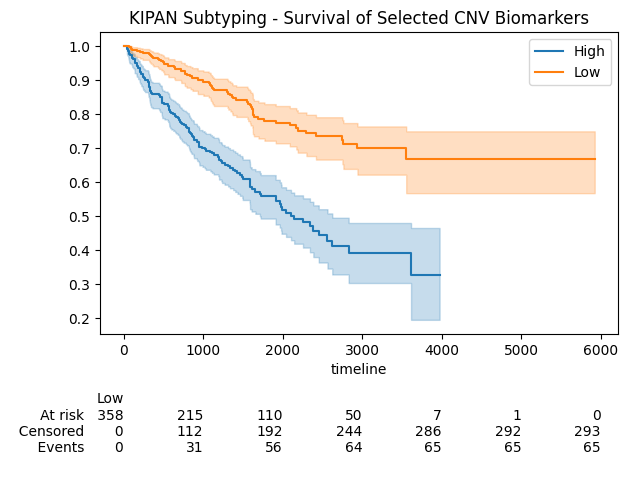

p-value: 3.0172157914159796e-12


In [ ]:
  ax = plt.subplot(111)
  m_1 = new_df['cnv']["risk"] == "high"
  kmf_1 = KaplanMeierFitter()
  kmf_1.fit(durations=T['cnv'][m_1], event_observed=E['cnv'][m_1], label="High")
  kmf_1.plot_survival_function(ax=ax)
  kmf_1.fit(T['cnv'][~m_1], event_observed=E['cnv'][~m_1], label="Low")
  kmf_1.plot_survival_function(ax=ax, at_risk_counts=True)
  plt.title(f"KIPAN Subtyping - Survival of Selected CNV Biomarkers")
  plt.show()

  results = logrank_test(T['cnv'][m_1], T['cnv'][~m_1], event_observed_A=E['cnv'][m_1], event_observed_B=E['cnv'][~m_1])
  print("p-value: " + str(results.p_value))

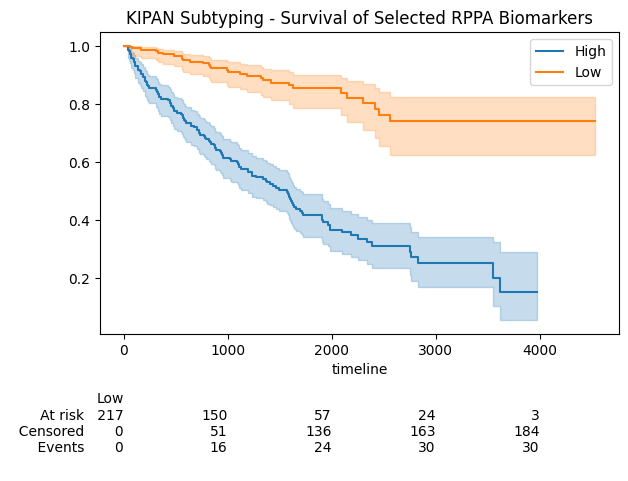

p-value: 7.814437486483674e-20


In [ ]:
  ax = plt.subplot(111)
  m_1 = new_df['rppa']["risk"] == "high"
  kmf_1 = KaplanMeierFitter()
  kmf_1.fit(durations=T['rppa'][m_1], event_observed=E['rppa'][m_1], label="High")
  kmf_1.plot_survival_function(ax=ax)
  kmf_1.fit(T['rppa'][~m_1], event_observed=E['rppa'][~m_1], label="Low")
  kmf_1.plot_survival_function(ax=ax, at_risk_counts=True)
  plt.title(f"KIPAN Subtyping - Survival of Selected RPPA Biomarkers")
  plt.show()

  results = logrank_test(T['rppa'][m_1], T['rppa'][~m_1], event_observed_A=E['rppa'][m_1], event_observed_B=E['rppa'][~m_1])
  print("p-value: " + str(results.p_value))

# BRCA Subtyping

### Import marker genes

In [ ]:
# Loading in marker genes per modality
with open("results/brca/marker_genes.json",'r+') as file:
    genes = json.load(file)

In [ ]:
chosen_genes = {}
for modality in genes:
  chosen_genes[modality] = np.array(genes[modality])
  print(f"{modality}: {len(chosen_genes[modality])}")

rna: 705
mirna: 0
methylation: 0


### Import count bulk data and phenotype data (survival data)

In [ ]:
datasets = {
            'rna': '../data/breast/RNASeq.csv',
            'mirna': '../data/breast/miRNASeq.csv',
            'methylation': '../data/breast/Methylation.csv',
}

labels = '../data/breast/Clinical.csv'

In [ ]:
data = {}
pheno = {}
result = {}

for modality in datasets:
  data[modality] = pd.read_csv(datasets[modality], index_col=0, delimiter=",")  ## import your bulk dataset
  #inter[modality] = pd.read_csv("PAAD/inter_PAAD.csv").iloc[:, 1:].values.reshape(1, -1)[0] ## disregard this

  #data = data.filter(items=inter) ## disregard this
  pheno[modality] = pd.read_csv(labels, index_col=0) ## phenotype information e.g survival data
  result[modality] = pd.concat([pheno[modality], data[modality]], axis=1) ## merging the bulk and phenotype data
  result[modality].dropna(inplace=True)

  result[modality].rename(
      columns={"survival_time": "duration", "status": "event"},
      inplace=True,
  )

### Filter out non-marker genes from result dataframe

In [ ]:
filtered_result = {}

for modality in chosen_genes:
  DEG_genes = np.append(chosen_genes[modality], ["duration", "event"])
  filtered_result[modality] = result[modality].filter(DEG_genes) ## filter out non-marker genes from dataset

### Run cox-regression

In [ ]:
from lifelines import CoxPHFitter

new_df = {}
info = {}
T = {}
E = {}

for modality in datasets:
  cph = CoxPHFitter(penalizer=0.1) ## initialise cox regression model
  cph.fit(filtered_result[modality], duration_col="duration", event_col="event") ## run cox regression

  info[modality] = cph.summary ## regression summary
  DEG_exp = filtered_result[modality]
  DEG_coef = info[modality].T.filter(chosen_genes[modality]).iloc[0] ## get feature (genes) coefficients
  exp = DEG_exp.iloc[:, :-2].values ## get genes expression alone (apart from survival data)
  coef = DEG_coef.values.reshape(-1, 1)
  risk_scores = np.dot(exp, coef) ## matrix multiplication (gene1 expression * coefficient of gene1) = risk score of gene1

  ## Here we create a new dataframe with the risk scores for each marker genes, thats how you stratify between high and background risk patients
  new_df[modality] = DEG_exp.iloc[:, -2:]
  new_df[modality]["scores"] = risk_scores
  median_risk = np.median(risk_scores)
  risk = ["high" if i >= median_risk else "low" for i in risk_scores] ## patient straticication using median risk score
  new_df[modality]["risk"] = risk
  new_df[modality].reset_index(inplace=True)
  new_df[modality]

  T[modality] = new_df[modality]["duration"].values
  E[modality] = new_df[modality]["event"].values

<ipython-input-36-b6291c979d74>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df[modality]["scores"] = risk_scores
<ipython-input-36-b6291c979d74>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df[modality]["risk"] = risk
<ipython-input-36-b6291c979d74>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

### Create KM-PLOT

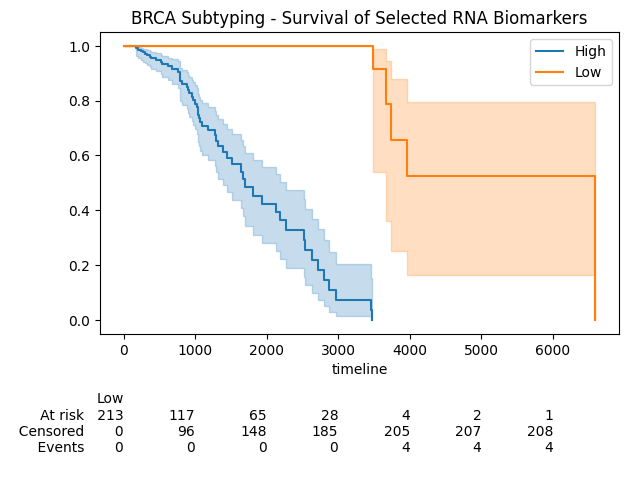

p-value: 2.1194052809905055e-30


In [ ]:
  ax = plt.subplot(111)
  m_1 = new_df['rna']["risk"] == "high"
  kmf_1 = KaplanMeierFitter()
  kmf_1.fit(durations=T['rna'][m_1], event_observed=E['rna'][m_1], label="High")
  kmf_1.plot_survival_function(ax=ax)
  kmf_1.fit(T['rna'][~m_1], event_observed=E['rna'][~m_1], label="Low")
  kmf_1.plot_survival_function(ax=ax, at_risk_counts=True)
  plt.title(f"BRCA Subtyping - Survival of Selected RNA Biomarkers")
  plt.show()

  results = logrank_test(T['rna'][m_1], T['rna'][~m_1], event_observed_A=E['rna'][m_1], event_observed_B=E['rna'][~m_1])
  print("p-value: " + str(results.p_value))